# todo

! kolejka wątków jeśli jest ich za dużo

! zapis wyników

! variance / std dev ([Welford Algorithm](https://gist.github.com/alexalemi/2151722))

usunąć period_avg z outputu

~~predictor/corrector i~~ zobaczyc jaka jest roznica

domyślne wartości SDE_VarIndependent

~~rozdzielanie parametrów~~

~~uruchamianie na dowolnym gridzie~~

~~zrobić wektor rhs~~

~~porządek w plikach~~

~~zamienic hardcodowane nazwy position, velocity na to co trzeba~~

~~ścieżki~~

~~sde.rhs = ... # setter~~

~~czyszczenie przestrzeni nazw jako extra feature~~

~~warningi jesli zmienne juz istnieja w przestrzeni globalnej~~

okresowe położenie

walidacja i performance

porównanie szumów kuby i curanda

dodać [metodę Adamsa-Bashfortha / Adamsa-Moultona](https://en.wikiversity.org/wiki/Adams-Bashforth_and_Adams-Moulton_methods) jako lepszy zamiennik RK4

# sympy

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pickle
import collections
from IPython.display import display
from sympy.printing import ccode
from sympy import cos, Symbol, symbols, Function, init_printing, Float
import sympy
import numpy as np
import pandas as pd
from mako.template import Template
from mako.lookup import TemplateLookup
import subprocess
import six
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.tools import clear_context_caches
from pycuda.compiler import SourceModule
import numpy as np
from math import ceil
import pycuda.gpuarray as gpuarray
import logging
from functools import reduce
import pprint

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1200)

class SDE_Param:
    def __init__(self, name, value):
        self.name = name
        self.value = value
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'parameter'
        if not isinstance(self.value, collections.Iterable):
            self.value = [self.value]
        new_data['values'] = np.array(self.value)
        
        data.loc[self.name] = new_data
        
class SDE_VarDependent:
    def __init__(self, name, initial_value, derivative_order):
        self.name = name
        self.initial_value = initial_value
        self.derivative_order = derivative_order
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'dependent variable'
        new_data['values'] = self.initial_value
        new_data['derivative_order'] = self.derivative_order
        
        data.loc[self.name] = new_data
        
class SDE_VarIndependent:
    def __init__(self, name, initial_value, step):
        self.name = name
        self.initial_value = initial_value
        self.step = step
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'independent variable'
        new_data['values'] = self.initial_value
        new_data['step'] = self.step
        
        data.loc[self.name] = new_data
        
class SDE_Function:
    def __init__(self, name, sympy_function):
        self.name = name
        self.s = sympy_function
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'function'

        data.loc[self.name] = new_data

class SDE_Noise:
    # https://docs.nvidia.com/cuda/curand/device-api-overview.html#distributions
    def __init__(self, name, noise_type):
        ''' noise : ['uniform', 'normal'] '''
        self.name = name
        self.s = Symbol(self.name)
        self.noise_type = noise_type
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'noise'
        new_data['values'] = {'noise type': self.noise_type}

        data.loc[self.name] = new_data

class bidict(dict):
    def __init__(self, *args, **kwargs):
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 
    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        
    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

class SDE:
    def __init__(self, *values):
        logging.getLogger().setLevel(logging.INFO)
        
        self._rhs = None
        self.rhs_string = None
        self.settings = None
        self.lookup = bidict() # maps name to data index in mako
        self.columns = ['sympy_symbol', 'type', 'values', 'step', 'derivative_order']
        self.data = pd.DataFrame(columns=self.columns, dtype='object')
        
        globals_dict = globals()
        for value in values:
            if value.name in globals_dict.keys():
                logging.warning('Value \'{}\' already defined, overwriting...'.format(value.name))
            value.fill_data(self.data)
            globals_dict[value.name] = value.s
    @property
    def rhs(self):
        return self._rhs
    @rhs.setter
    def rhs(self, value):
        self._rhs = value
    def deglobalize(self):
        globals_dict = globals()
        for name in self.data.index.values:
            del globals_dict[name]
    def solve(self, settings):
        self.settings = settings
        self.preprocess_settings()
        if self.settings.get('debug', {}).get('enabled', False):
            logging.getLogger().setLevel(logging.DEBUG)
        # self.deglobalize()
        self.rhs_string = [self.get_c_code(rhs_item) for rhs_item in self._rhs]
        logging.info('RHS: '+str(self.rhs_string))
        self.generate_cuda_code()
        return self.run_cuda()
    def get_c_code(self, rhs):
        code = ccode(rhs.subs(self._get_subs())) \
            .replace('cos', 'cosf') \
            .replace('sin', 'sinf') \
            .replace('pow', 'powf')
            
        noise_replacements = {'uniform':'curand_uniform(curand_states[idx])',
                              'normal' :'curand_normal(curand_states[idx])'}
        for noise in self.row_iterator('type', 'noise'):
            code = code.replace(noise.Index, noise_replacements[noise.values['noise type']])
        
        return code
    def _get_subs(self): # FIXME
        subs = {}
        for row in self.row_iterator('type', 'parameter'):#self.data.loc[self.data['type'] == 'parameter'].iterrows():
            if len(row.values) == 1:
                subs[row.Index] = row.values[0]
        return subs
    def get_default_settings(self):
        return {
            'constants':{
                'steps_per_kernel_call' : 1000,
                'steps_per_period' : 1000,
                'periods' : 1000,                  # number of periods in the simulation
                'afterstep_every' : 1000,
            },
            'simulation':{
                'precision': 'float',          # ['float', 'double'] TODO: czy to ma sens? poprawić żeby było wszędzie
                'number_of_threads' : None,
                'block_size': None,
                'grid_size': None,
                'integration_method': 'rk4',    # ['euler', 'rk4']
                'paths': 1,                     # number of paths to sample
                'fit_to_warp_size': False,       # bump number of threads per block to warp multiple
#                 'samples':100,                # sample the position every N steps
#                 'transients_number':200,      # number of periods to ignore
#                 'transients_fraction':0.1,    # fraction of periods to ignore
#                 'transients_type':'fraction', # periods to ignore because of transients (fraction, number)
#                 'rng_seed':None,
#                 'precision':'single',         # precision of the floating-point numbers (single, double)
#                 'rng_generator':'kiss32', 
#                 'deterministic':False,        # do not generate any noises
            },
            'output':{
#                 'mode':'summary',  # output mode (summary, path)
#                 'format':'text',   # output file format (text, npy)
                 'destination':'./tmp/'
            },
            'gpu':{
                'cuda': True,
                'warp_size': 32,
                'max_threads_per_block': 1024,
                'max_blocks_per_grid': 2**31-1,
            },
            'debug':{
                'enabled':True,
            }
        }
    def preprocess_settings(self):
        block_size, grid_size, extra_threads = self._calculate_block_grid_size()
        msg = 'block: {}; grid: {}'.format(block_size, grid_size)
        if extra_threads != 0:
            msg += '; {} extra threads from warp optimization.'.format(extra_threads)
        logging.info(msg)
        self.settings['simulation']['block_size'] = block_size
        self.settings['simulation']['grid_size'] = grid_size
        self.settings['simulation']['extra_threads'] = extra_threads
        self.settings['simulation']['number_of_threads'] = reduce(lambda x,y : x*y, block_size + grid_size)
    def _calculate_block_grid_size(self):
        ######## calculate block & grid size
        # CUDA Occupancy Calculator
        # https://lxkarthi.github.io/cuda-calculator/
        s = self.settings
        
        block_size = None
        grid_size = None
        extra_threads = 0
        
        params_combinations = reduce(lambda x, y: x*y, [len(row.values) for row in self.row_iterator('type', 'parameter')])
        threads_needed = params_combinations * s['simulation']['paths']
        
        if s['simulation']['block_size'] is not None and s['simulation']['grid_size'] is not None:
            if s['simulation']['fit_to_warp_size']:
                logging.warning('Both block and grid size specified - ommiting \'fit_to_warp_size\' command.')
        elif s['simulation']['block_size'] is None and s['simulation']['grid_size'] is None:
            if threads_needed <= s['gpu']['max_threads_per_block']:
                if s['simulation']['fit_to_warp_size']:
                    block_size = (threads_needed + (s['gpu']['warp_size'] - threads_needed%s['gpu']['warp_size'])%s['gpu']['warp_size'], 1, 1)
                    grid_size = (1, 1, 1)
                    extra_threads = block_size[0] - threads_needed
                else:
                    block_size = (threads_needed, 1, 1)
                    grid_size = (1, 1, 1)
            else:
                if threads_needed < 512 * s['gpu']['max_blocks_per_grid']:
                    block_size = (512, 1, 1) # TODO: na pewno tyle? https://stackoverflow.com/a/9986748/1185254
                else:
                    block_size = (1024, 1, 1)
                blocks_needed = ceil(threads_needed / block_size[0])
                grid_size = (blocks_needed, 1, 1)
                extra_threads = blocks_needed * block_size[0] - threads_needed
        elif s['simulation']['grid_size'] is not None:
            if not isinstance(s['simulation']['grid_size'], collections.Iterable):
                grid_threads = int(s['simulation']['grid_size'])
                grid_size = (grid_threads, 1, 1)
            else:
                grid_threads = reduce(lambda x, y: x*y, s['simulation']['grid_size'])
                grid_size = s['simulation']['grid_size']
            block_threads = ceil(threads_needed / grid_threads)
            if s['simulation']['fit_to_warp_size']:
                extra_threads = block_threads
                block_threads = block_threads + (s['gpu']['warp_size'] - block_threads%s['gpu']['warp_size'])%s['gpu']['warp_size']
                extra_threads = block_threads - extra_threads
            block_size = (block_threads, 1, 1)
        elif s['simulation']['block_size'] is not None:
            if not isinstance(s['simulation']['block_size'], collections.Iterable):
                block_threads = int(s['simulation']['block_size'])
                block_size = (block_threads, 1, 1)
            else:
                block_threads = reduce(lambda x, y: x*y, s['simulation']['block_size'])
                block_size = s['simulation']['block_size']
            if s['simulation']['fit_to_warp_size']:
                extra_threads = block_threads
                block_threads = block_threads + (s['gpu']['warp_size'] - block_threads%s['gpu']['warp_size'])%s['gpu']['warp_size']
                extra_threads = block_threads - extra_threads
                block_size = (block_threads, 1, 1)
            grid_size = (ceil(threads_needed / block_threads), 1, 1)
        return block_size, grid_size, extra_threads
    def generate_cuda_code(self):
        lookup = TemplateLookup(directories=['./templates'], output_encoding='utf-8', encoding_errors='replace')
        sde_template = lookup.get_template('main.mako')
        kernel_source = sde_template.render(sde=self)

        with open("./kernel.cu", 'wb') as file:
            file.write(kernel_source)

        command = 'clang-format -style=google -i ./kernel.cu'.split()
        command = 'indent -linux -sob -l120 ./kernel.cu'.split()
        print(subprocess.check_output(command).decode('utf-8'))
    def row_iterator(self, col_name, values):
        if not (isinstance(values, collections.Iterable) and not isinstance(values, six.string_types)):
            values = [values]
        return self.data.loc[self.data[col_name].isin(values)][::-1].itertuples()
    def run_cuda(self):
        s = self.settings
        mod = SourceModule(open('./kernel.cu', 'r').read(), no_extern_c=True)

        ######## compute capabilities
        # https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities
        # Tesla K40: 3.5
        ######## indexing cheatsheet
        # https://cs.calvin.edu/courses/cs/374/CUDA/CUDA-Thread-Indexing-Cheatsheet.pdf
        ######## randoms
        # https://stackoverflow.com/questions/46169633/how-to-generate-random-number-inside-pycuda-kernel
        ######## mean / std dev / Welford's algorithm
        # https://stackoverflow.com/a/1934266/1185254
        # https://www.johndcook.com/blog/standard_deviation/

        init_func = mod.get_function("_Z10initkerneli")
        seed = np.int32(123456789)
        init_func(seed, block=s['simulation']['block_size'], grid=s['simulation']['grid_size'])

        ######## runs    
        # https://en.wikipedia.org/wiki/Name_mangling#How_different_compilers_mangle_the_same_functions
        number_of_dependent_vars = len(list(sde.row_iterator('type', 'dependent variable')))
        
        print(s['simulation']['number_of_threads'])
        gpu_summary = gpuarray.to_gpu(np.zeros((s['simulation']['number_of_threads'],number_of_dependent_vars*3,1), dtype=np.float32))

        kernel_calls = ceil(s['constants']['periods'] * s['constants']['steps_per_period'] / s['constants']['steps_per_kernel_call'])
        print('kernel_calls:', kernel_calls)

        mod.get_function("prepare_simulation")(block=s['simulation']['block_size'], grid=s['simulation']['grid_size']) # _Z18prepare_simulationPf
        for i in range(kernel_calls):
            mod.get_function("continue_simulation")(block=s['simulation']['block_size'], grid=s['simulation']['grid_size']) # _Z19continue_simulationv
        mod.get_function("end_simulation")(gpu_summary, block=s['simulation']['block_size'], grid=s['simulation']['grid_size']) # _Z14end_simulationv

        summary = gpu_summary.get()
        
        pprint.pprint(gpu_summary.shape)
        pprint.pprint(gpu_summary.get()[:,:])

        clear_context_caches()

        print("""
        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        """)
        
        return summary

height has been deprecated.



# user part:

In [59]:
%%time
import math

sde = SDE(
    SDE_Param('m', 1),
    SDE_Param('gamma', 0.1502*2*math.pi),
    SDE_Param('a', 1.721042*2*math.pi),
    SDE_Param('omega', 0.6*2*math.pi),
    SDE_Param('f', np.linspace(0.01*2*math.pi,0.15*2*math.pi,400)),
    SDE_Param('D', 0),
    SDE_Noise('xi', 'normal'),
    SDE_VarDependent('x', 0.0, 0),
    SDE_VarDependent('v', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  math.pi*2/(0.6*2*math.pi*1000)),
    SDE_Function('U', lambda x: -sympy.cos(x))
)
sde.rhs = [
    v,
    1.0 / m * (-gamma * v - sympy.diff(U(x), x) + a * sympy.cos(omega * t) + f + D * xi)
]
settings = sde.get_default_settings()
out = sde.solve(settings)

INFO:root:block: (400, 1, 1); grid: (1, 1, 1)
INFO:root:RHS: ['v', '1.0*f - 0.943734433138374*v - 1.0*sinf(x) + 10.813625807439*cosf(3.76991118430775*t)']



400
kernel_calls: 1000
(400, 6, 1)
array([[[ 2.0064852e+00],
        [-2.7760191e-04],
        [ 4.3268735e+06],
        [-4.6435395e-01],
        [ 7.3390827e-02],
        [ 3.0097300e+05]],

       [[ 2.0064981e+00],
        [-2.7606168e-04],
        [ 4.3267735e+06],
        [-4.6179301e-01],
        [ 7.5973310e-02],
        [ 3.0096238e+05]],

       [[ 2.0065124e+00],
        [-2.7457159e-04],
        [ 4.3266480e+06],
        [-4.5923418e-01],
        [ 7.8557901e-02],
        [ 3.0095216e+05]],

       ...,

       [[ 2.2429609e+00],
        [ 6.7557293e-01],
        [ 3.9287545e+06],
        [ 1.1259031e+03],
        [ 5.6386554e+02],
        [ 1.0747631e+11]],

       [[ 2.5994158e+00],
        [ 6.8043071e-01],
        [ 3.9282788e+06],
        [ 1.1340536e+03],
        [ 5.6920221e+02],
        [ 1.0880884e+11]],

       [[ 3.5832572e+00],
        [ 6.8930441e-01],
        [ 3.9265962e+06],
        [ 1.1488625e+03],
        [ 5.7098260e+02],
        [ 1.1283885e+11]]], dty

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


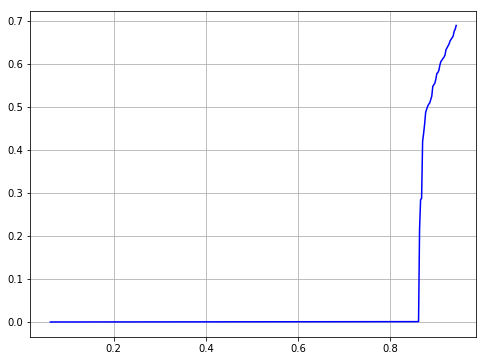

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0.01*2*math.pi,0.15*2*math.pi,400), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


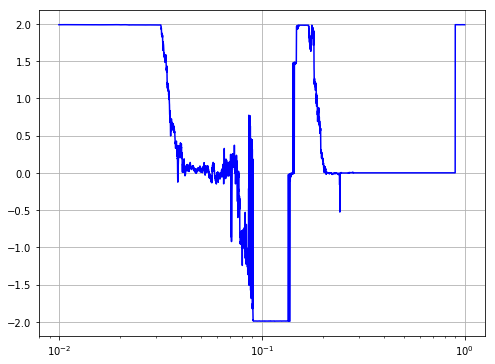

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.semilogx(np.logspace(-2,0,4096), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


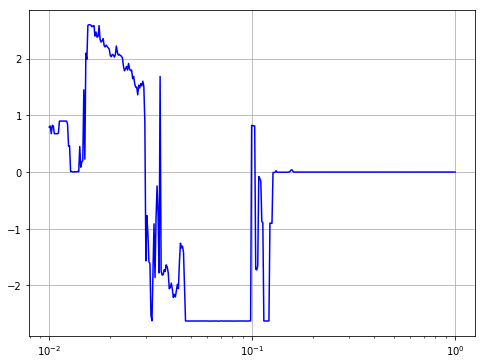

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.semilogx(np.logspace(-2,0,400), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


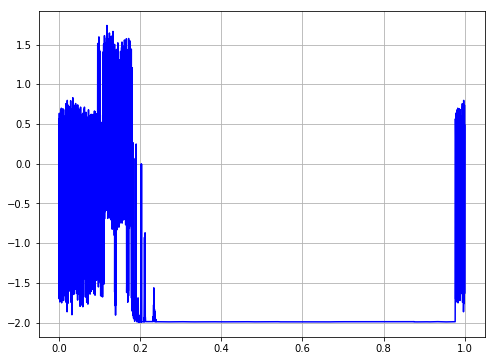

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0,1,4096), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

# sneak peeks:

In [ ]:
print('data:\n', sde.data)

import pprint
print('\n\ndefault settings:\n')
pprint.pprint(sde.get_default_settings())

init_printing()
print('\n\nequation:\n')
display(sde.rhs)
print('\n\nfree symbols:\n')
display(list(eq.free_symbols for eq in sde.rhs))
print('\n\nequation with substituted values:\n')
display(list(eq.subs(sde._get_subs()) for eq in sde.rhs))
print('\n\nfree symbols in equation with substituted values:\n')
display(list(eq.subs(sde._get_subs()).free_symbols for eq in sde.rhs))
# display(rhs.subs(Value.subs_uneval()))

# testy

### 1

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def f(z, t):
    x, v = z
    dzdt = [np.cos(v), np.cos(x)]
    return dzdt

z0 = [0, 10*np.sin(np.pi/4)]
t = [0.001*x for x in range(8000)]

sol = odeint(f, z0, t)

plt.plot(sol[:, 0], 'r')
plt.plot(sol[:, 1], 'g')
plt.show()

print(sol)
print(np.mean(np.array(sol), axis=0))

vals_solver = np.array([*sol[-1,:],*np.mean(np.array(sol), axis=0)])
print(vals_solver)

In [ ]:
import pprint

sde = SDE(
    SDE_Param('m', 1.0),
    SDE_Param('f', 9.8125),
    SDE_VarDependent('position', 0.0, 0),
    SDE_VarDependent('velocity', 10*np.sin(np.pi/4), 1),
    SDE_VarIndependent('t', 0.0, 0.001),
)
sde.rhs = [sympy.cos(velocity), sympy.cos(position)]
settings = sde.get_default_settings()
settings['constants']['steps_per_kernel_call'] = 1000
settings['constants']['steps_per_period'] = 8000
settings['constants']['periods'] = 1
settings['simulation']['integration_method'] = 'rk4'
pprint.pprint(settings)
print("""
        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        """)
vals_sde = sde.solve(settings)
vals_sde = np.array([vals_sde[0,3,0],vals_sde[0,0,0],vals_sde[0,4,0],vals_sde[0,1,0]])
print(vals_sde)

In [ ]:
print('rk4')
print('x','v','mean_x','mean_v')
vals_solver - vals_sde

In [ ]:
print('euler')
print('x','v','mean_x','mean_v')
vals_solver - vals_sde

### 2

In [ ]:
sde = SDE(
    SDE_Param('b', 0.25),
    SDE_Param('c', 5.0),
    SDE_VarDependent('position', np.pi - 0.1, 0),
    SDE_VarDependent('velocity', 0.0, 1),
    SDE_VarIndependent('t', 0.0, 0.001),
)
rhs = -b*velocity - c*sympy.sin(position)
settings = sde.get_default_settings()
settings['simulation']['steps_per_period'] = settings['simulation']['steps_per_kernel_call'] = 10000
print(settings)
sde.solve(rhs, settings)

In [ ]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm,os
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D

initial_state = [0.1, 0, 0, 1,1,1]
a = 4
time_points = np.linspace(0, 100, 10000)

def my_system(current_state, t):
    theta1, theta2, theta3, omega1, omega2, omega3 = current_state

    d2theta1_dt2 = -a*(2*theta1-theta2-theta3)
    d2theta2_dt2 = -a*(2*theta2-theta1-theta3)
    d2theta3_dt2 = -a*(2*theta3-theta1-theta2)

    return [ omega1, omega2, omega3, d2theta1_dt2, d2theta2_dt2, d2theta3_dt2]

xyz = odeint(my_system, initial_state, time_points)

theta1 = xyz[:, 0]
theta2 = xyz[:, 1]
theta3 = xyz[:, 2]

fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')
ax.xaxis.set_pane_color((1,1,1,1))
ax.yaxis.set_pane_color((1,1,1,1))
ax.zaxis.set_pane_color((1,1,1,1))
ax.plot(theta1, theta2, theta3, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('plot')
plt.show()

### 3

In [ ]:
sde = SDE(
    SDE_Param('m', 0.1),
    SDE_Param('gamma', 1.0),
    SDE_Param('a', 8.55),
    SDE_Param('omega', 12.38),
    SDE_Param('f', 0.5),
    SDE_VarDependent('position', 0.0, 0),
    SDE_VarDependent('velocity', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  2*np.pi/3000),
    SDE_Function('U', lambda x: sympy.sin(2*np.pi*x))
)
rhs = [
    velocity,
    1.0 / m * (-gamma * velocity - sympy.diff(U(position), position) + a * sympy.cos(omega * t) + f)
]
settings = sde.get_default_settings()
settings['simulation']['periods'] = 1000
settings['simulation']['steps_per_period'] = 800
pprint.pprint(settings)
sde.solve(rhs, settings)

######

print('data:\n', sde.data)

init_printing()
print('\n\nequation:\n')
display(sde.rhs)
print('\n\nfree symbols:\n')
display(list(eq.free_symbols for eq in sde.rhs))
print('\n\nequation with substituted [0]values:\n')
display(list(eq.subs(sde.get_0subs()) for eq in sde.rhs))
# display(rhs.subs(Value.subs_uneval()))

# notes

In [ ]:
# generowanie liczb losowych

import numpy as np
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray

code = """
    #include <curand_kernel.h>

    const int nstates = %(NGENERATORS)s;
    __device__ curandState_t* states[nstates];

    __global__ void initkernel(int seed)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx < nstates) {
            curandState_t* s = new curandState_t;
            if (s != 0) {
                curand_init(seed, tidx, 0, s);
            }

            states[tidx] = s;
        }
    }

    __global__ void randfillkernel(float *values, int N)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx < nstates) {
            curandState_t s = *states[tidx];
            for(int i=tidx; i < N; i += blockDim.x * gridDim.x) {
                values[i] = curand_uniform(&s);
            }
            *states[tidx] = s;
        }
    }
"""

N = 1
mod = SourceModule(code % { "NGENERATORS" : N }, no_extern_c=True)
init_func = mod.get_function("_Z10initkerneli")
fill_func = mod.get_function("_Z14randfillkernelPfi")

seed = np.int32(123456789)
nvalues = 10 * N
init_func(seed, block=(N,1,1), grid=(1,1,1))
gdata = gpuarray.zeros(nvalues, dtype=np.float32)
print(gdata)
fill_func(gdata, np.int32(nvalues), block=(N,1,1), grid=(1,1,1))
print(gdata)

In [ ]:
#plotly

import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

m = 0.2
g = 9.81
steps = 100

alpha = 89
v_0 = 30
f = np.array([0, -m*g]) # x, y
pos = np.zeros((steps, 2))
v = np.zeros((steps, 2))
v[0, :] = v_0 * np.cos(np.radians(alpha)), v_0 * np.sin(np.radians(alpha))
a = f/m
t = 0
dt = 0.1

last_i = 0
for i in range(steps-1):
    last_i = i
    v[i+1, :] = v[i, :] + a*dt
    pos[i+1, :] = pos[i, :] + v[i]*dt
    if pos[i+1, 1] < 0:
        break

poss = go.Scatter(
    x=pos[:last_i,0],
    y=pos[:last_i,1],
    mode = 'markers'
)

vs = go.Scatter(
    x=pos[:last_i,0],
    y=np.abs(v[:last_i,1]),
    mode = 'markers'
)

data = [poss, vs]

fig = go.Figure(data=data)

iplot(fig)

In [ ]:
# runge-kutta 4th order

# https://pl.wikipedia.org/wiki/Algorytm_Rungego-Kutty
# https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/

# predictor-corrector

# http://www.cmth.ph.ic.ac.uk/people/a.mackinnon/Lectures/compphys/node12.html
idx//paths

In [ ]:
import functools
import operator
def indices_1D_ND(index, arrs):
    '''
    :param arrs:  array of arrays containing variables/parameters values
                  e.g.: [[0], [0,1,2,3,4,5,6], range(95,105), [2], [1], [0.1, 0.01, 0.001]]
    :param index: if all possible values combinations were produced from respectible subarrays and then flattened into 1D
                  this is gonna be an index of values set in such 1D array
    :returns:     array of indices for accessing desired values in arrs (indices in the same order as arrs)
    :raises ValueError: if index out of range
    '''
    indices_reversed = []
    lens = [len(x) for x in arrs]
    max_index = functools.reduce(operator.mul, lens, 1)
    if index < 0 or index >= max_index:
        raise ValueError('index >= {}'.format(max_index))
    for l in lens:
        indices_reversed.append(index%l)
        index = index // l
    return(indices_reversed)

aaa = [[0], [0,1,2,3,4,5,6], range(95,98), [2], [1], [0.1, 0.01, 0.001]]
x = 0
while(True):
    try:
        print(indices_1D_ND(x, aaa))
        x += 1
    except Exception:
        break

In [ ]:
import math
class Welford(object):
    """ Implements Welford's algorithm for computing a running mean
    and standard deviation as described at: 
        http://www.johndcook.com/standard_deviation.html
    can take single values or iterables
    Properties:
        mean    - returns the mean
        std     - returns the std
        meanfull- returns the mean and std of the mean
    Usage:
        >>> foo = Welford()
        >>> foo(range(100))
        >>> foo
        <Welford: 49.5 +- 29.0114919759>
        >>> foo([1]*1000)
        >>> foo
        <Welford: 5.40909090909 +- 16.4437417146>
        >>> foo.mean
        5.409090909090906
        >>> foo.std
        16.44374171455467
        >>> foo.meanfull
        (5.409090909090906, 0.4957974674244838)
    """

    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
#         lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)
    
import numpy as np
def aaa(x):
    for x in range(x):
        yield x*1000
#     yield -x*10000
lst = list(aaa(10000))
print(lst[-10:])
print(np.mean(lst))
print(np.std(lst))
Welford(lst)